In [37]:
import mysql.connector
from pyspark.sql import SparkSession
import pandas as pd

In [38]:
conn = mysql.connector.connect(user='', password='', host='localhost', database='impacta_analise_sentimentos')

# Criar um objeto cursor para executar consultas SQL
cursor = conn.cursor()

# Consulta SQL
sql_query = "describe impacta_analise_sentimentos.movies"

# Executar a consulta
cursor.execute(sql_query)

# Recuperar os resultados da consulta
results = cursor.fetchall()

# Exibir os resultados
for row in results:
    print(row)


('movieId', 'int', 'YES', '', None, '')
('title', 'varchar(255)', 'YES', '', None, '')
('genres', 'varchar(255)', 'YES', '', None, '')


In [39]:
df_movies = pd.read_sql('select * from impacta_analise_sentimentos.movies', conn)
df_rating = pd.read_sql('select * from impacta_analise_sentimentos.rating', conn)

C:\Users\jvtsp\AppData\Local\Temp\ipykernel_18648\2493713743.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_movies = pd.read_sql('select * from impacta_analise_sentimentos.movies', conn)
C:\Users\jvtsp\AppData\Local\Temp\ipykernel_18648\2493713743.py:2: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df_rating = pd.read_sql('select * from impacta_analise_sentimentos.rating', conn)


In [40]:
filmes = df_movies
filmes.columns = ["filmeId", "titulo", "generos"]
filmes = filmes.set_index("filmeId")
filmes.head()

,titulo,generos
filmeId,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;
2,Jumanji (1995),Adventure|Children|Fantasy;;
3,Grumpier Old Men (1995),Comedy|Romance;;
4,Waiting to Exhale (1995),Comedy|Drama|Romance;;
5,Father of the Bride Part II (1995),Comedy;;


In [41]:
notas = df_rating
notas.columns = ["usuarioId", "filmeId", "nota", "momento"]
notas.head()

,usuarioId,filmeId,nota,momento
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [42]:
notas.describe()

,usuarioId,filmeId,nota,momento
count,1.048575e+06,1.048575e+06,1.048575e+06,1.048575e+06
mean,5.074567e+03,2.784735e+04,3.525809e+00,1.267337e+09
std,2.868723e+03,4.967106e+04,1.060796e+00,2.505764e+08
min,1.000000e+00,1.000000e+00,5.000000e-01,8.254319e+08
25%,2.633000e+03,1.220000e+03,3.000000e+00,1.057267e+09
50%,4.976000e+03,3.273000e+03,3.500000e+00,1.254270e+09
75%,7.570000e+03,3.639700e+04,4.000000e+00,1.489898e+09
max,1.008200e+04,2.889410e+05,5.000000e+00,1.689838e+09


# Primeira tentativa de recomendação: heurística de total de votos

In [43]:
total_de_votos = notas["filmeId"].value_counts()
total_de_votos.head()

filmeId
318     3735
356     3505
296     3325
2571    3320
593     3172
Name: count, dtype: int64

In [44]:
filmes['total_de_votos'] = total_de_votos
filmes.head()

,titulo,generos,total_de_votos
filmeId,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0
2,Jumanji (1995),Adventure|Children|Fantasy;;,920.0
3,Grumpier Old Men (1995),Comedy|Romance;;,475.0
4,Waiting to Exhale (1995),Comedy|Drama|Romance;;,72.0
5,Father of the Bride Part II (1995),Comedy;;,487.0


In [45]:
filmes.sort_values("total_de_votos", ascending = False).head(10)

,titulo,generos,total_de_votos
filmeId,,,
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller;;,3325.0
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller;;,3325.0
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller;;,3325.0
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller;;,3325.0


In [46]:
notas_medias = notas.groupby("filmeId").mean()["nota"]
notas_medias.head()

filmeId
1    3.887833
2    3.291848
3    3.141053
4    3.215278
5    3.144764
Name: nota, dtype: float64

In [47]:
filmes["nota_media"] = notas_medias
filmes.sort_values("total_de_votos", ascending = False).head(10)

,titulo,generos,total_de_votos,nota_media
filmeId,,,,
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0,4.048787
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0,4.048787
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0,4.048787
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0,4.048787
356,Forrest Gump (1994),Comedy|Drama|Romance|War;;,3505.0,4.048787
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller;;,3325.0,4.194737
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller;;,3325.0,4.194737
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller;;,3325.0,4.194737
296,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller;;,3325.0,4.194737


# Uma segunda heurística: nota média e filtrando votos

In [48]:
filmes.sort_values("nota_media", ascending = False).head(10)

,titulo,generos,total_de_votos,nota_media
filmeId,,,,
288941,Mixed Baggage (2023),Comedy|Drama|Romance;;,1.0,5.0
135242,On the Way to School (2013),Documentary;;,1.0,5.0
135854,Eddie Izzard: Sexie (2003),Comedy;;,1.0,5.0
205759,Midnight Diner 2 (2016),Drama;;,1.0,5.0
135697,Morgan Murphy: Irish Goodbye (2014),Comedy;;,1.0,5.0
206064,Secret Millionaire (2018),Romance;;,1.0,5.0
135623,The Fluffy Movie (2014),Comedy;;,1.0,5.0
135621,Deepsea Challenge 3D (2014),Documentary;;,1.0,5.0
207095,Windy City Heat (2003),Comedy|Documentary;;,1.0,5.0


In [49]:
filmes.query("total_de_votos >= 10").sort_values("nota_media", ascending = False).head(10)

,titulo,generos,total_de_votos,nota_media
filmeId,,,,
103210,Fullmetal Alchemist: The Sacred Star of Milos ...,Action|Adventure|Animation;;,12.0,4.541667
286897,Spider-Man: Across the Spider-Verse (2023),Action|Adventure|Animation|Sci-Fi;;,16.0,4.500000
100044,Human Planet (2011),Documentary;;,12.0,4.500000
89554,Zindagi Na Milegi Dobara (2011),Adventure|Comedy|Drama|Romance;;,15.0,4.500000
170777,There Once Was a Dog (1982),Animation|Children|Comedy;;,11.0,4.500000
58425,Heima (2007),Documentary;;,10.0,4.500000
171495,Cosmos,(no genres listed);;,21.0,4.452381
171011,Planet Earth II (2016),Documentary;;,68.0,4.441176
2330,Hands on a Hard Body (1996),Comedy|Documentary;;,29.0,4.431034


In [50]:
filmes_com_mais_de_50_votos = filmes.query("total_de_votos >= 50")
filmes_com_mais_de_50_votos.sort_values("nota_media", ascending = False).head(10)


,titulo,generos,total_de_votos,nota_media
filmeId,,,,
171011,Planet Earth II (2016),Documentary;;,68.0,4.441176
170705,Band of Brothers (2001),Action|Drama|War;;,91.0,4.428571
159817,Planet Earth (2006),Documentary;;,92.0,4.375000
202439,Parasite (2019),Comedy|Drama;;,397.0,4.272040
116897,Wild Tales (2014),Comedy|Drama|Thriller;;,88.0,4.267045
2019,Seven Samurai (Shichinin no samurai) (1954),Action|Adventure|Drama;;,572.0,4.252622
2019,Seven Samurai (Shichinin no samurai) (1954),Action|Adventure|Drama;;,572.0,4.252622
2959,Fight Club (1999),Action|Crime|Drama|Thriller;;,2638.0,4.223654
2959,Fight Club (1999),Action|Crime|Drama|Thriller;;,2638.0,4.223654


In [51]:
eu_assisti = [1, 21, 19, 10, 7, 2]
filmes.loc[eu_assisti]

,titulo,generos,total_de_votos,nota_media
filmeId,,,,
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
21,Get Shorty (1995),Comedy|Crime|Thriller;;,799.0,3.520651
21,Get Shorty (1995),Comedy|Crime|Thriller;;,799.0,3.520651
21,Get Shorty (1995),Comedy|Crime|Thriller;;,799.0,3.520651
21,Get Shorty (1995),Comedy|Crime|Thriller;;,799.0,3.520651


In [52]:
aventura_infantil_e_fantasia = filmes_com_mais_de_50_votos.query("generos=='Adventure|Children|Fantasy'")
aventura_infantil_e_fantasia.drop(eu_assisti, errors='ignore').sort_values("nota_media", ascending = False).head(10)

,titulo,generos,total_de_votos,nota_media
filmeId,,,,


# Procurar usuários "similares"

- joão deu nota 4 no filme toy story
- maria deu nota 5 no filme toy story
- paulo deu nota 3 no filme toy story
- joana deu nota 3.5 no filme toy story

x-y ==> distância

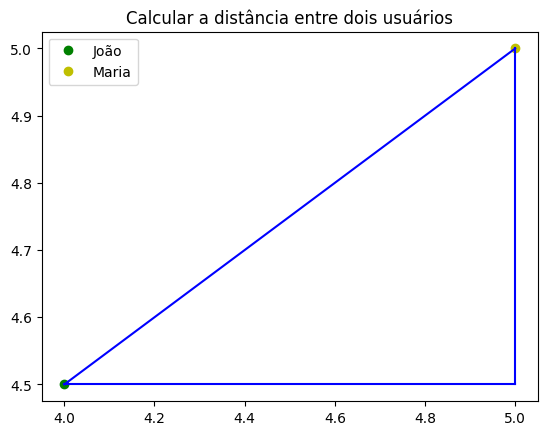

In [53]:
import matplotlib.pyplot as plt
plt.plot(4, 4.5, "go")
plt.plot(5, 5, "yo")
plt.legend(["João", "Maria"])
plt.title("Calcular a distância entre dois usuários")

plt.plot([4, 5], [4.5, 4.5], color="b", linestyle="-")
plt.plot([4, 5], [4.5, 5], color="b", linestyle="-")
plt.plot([5, 5], [4.5, 5], color="b", linestyle="-")

In [54]:
import numpy as np

joao = np.array([4, 4.5])
maria = np.array([5, 5])

joao - maria

array([-1. , -0.5])

In [55]:
from math import sqrt

def pitagoras(a,b):
  (delta_x, delta_y) = a - b
  return sqrt(delta_x * delta_x + delta_y * delta_y)

pitagoras(joao, maria)

1.118033988749895

In [56]:
def pitagoras(a,b):
  return np.linalg.norm(a - b)

pitagoras(joao, maria)

1.118033988749895

Text(0.5, 1.0, 'Calcular a distância entre usuários')

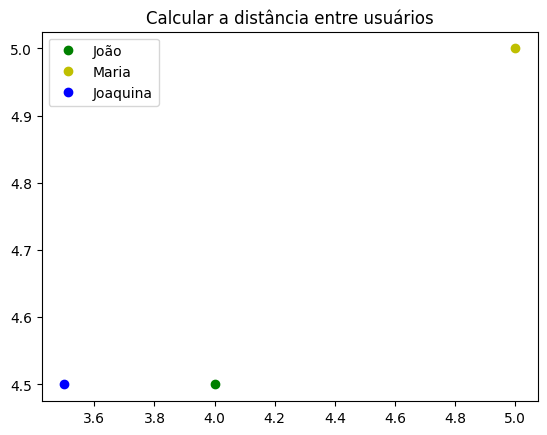

In [57]:
import matplotlib.pyplot as plt
plt.plot(4, 4.5, "go")
plt.plot(5, 5, "yo")
plt.plot(3.5, 4.5, "bo")
plt.legend(["João", "Maria", "Joaquina"])
plt.title("Calcular a distância entre usuários")


In [58]:
joaquina = np.array([3.5, 4.5])

print(pitagoras(joao, maria))
print(pitagoras(joao, joaquina))

1.118033988749895
0.5


# Distância entre usuários do dataset

In [59]:
def distancia_de_vetores(a,b):
  return np.linalg.norm(a - b)


In [60]:
def notas_do_usuario(usuario):
  notas_do_usuario = notas.query("usuarioId==%d" % usuario)
  notas_do_usuario = notas_do_usuario[["filmeId", "nota"]].set_index("filmeId")
  return notas_do_usuario

In [61]:
usuario1 = notas_do_usuario(1)
usuario4 = notas_do_usuario(4)

In [62]:
usuario1.head()

,nota
filmeId,
1,4.0
110,4.0
158,4.0
260,4.5
356,5.0


In [63]:
usuario4.head()

,nota
filmeId,
260,5.0
318,5.0
356,5.0
595,4.5
858,3.0


In [64]:
diferencas = usuario1.join(usuario4, lsuffix="_esquerda", rsuffix="_direita").dropna()
distancia_de_vetores(diferencas['nota_esquerda'], diferencas['nota_direita'])

1.3228756555322954

In [65]:
def distancia_de_usuarios(usuario_id1, usuario_id2):
  notas1 = notas_do_usuario(usuario_id1)
  notas2 = notas_do_usuario(usuario_id2)
  diferencas = notas1.join(notas2, lsuffix="_esquerda", rsuffix="_direita").dropna()
  distancia =  distancia_de_vetores(diferencas['nota_esquerda'], diferencas['nota_direita'])
  return [usuario_id1, usuario_id2, distancia]

In [66]:
distancia_de_usuarios(1,4)

[1, 4, 1.3228756555322954]

In [67]:
quantidade_de_usuarios = len(notas['usuarioId'].unique())
print("Temos %d usuarios" % quantidade_de_usuarios)

Temos 10082 usuarios


In [68]:
def distancia_de_todos(voce_id):
  distancias = []
  for usuario_id in notas['usuarioId'].unique():
    informacoes = distancia_de_usuarios(voce_id, usuario_id)
    distancias.append(informacoes)
  return distancias

distancia_de_todos(1)[:5]

[[1, 1, 0.0],
 [1, 2, 1.7320508075688772],
 [1, 3, 0.5],
 [1, 4, 1.3228756555322954],
 [1, 5, 3.5]]

In [69]:
def distancia_de_todos(voce_id):
  todos_os_usuarios = notas['usuarioId'].unique()
  distancias = [distancia_de_usuarios(voce_id, usuario_id) for usuario_id in todos_os_usuarios]
  distancias = pd.DataFrame(distancias, columns = ["voce", "outra_pessoa", "distancia"])
  return distancias

distancia_de_todos(1).head()

,voce,outra_pessoa,distancia
0,1,1,0.000000
1,1,2,1.732051
2,1,3,0.500000
3,1,4,1.322876
4,1,5,3.500000


In [70]:
notas_do_usuario(1).join(notas_do_usuario(5), lsuffix="_1", rsuffix="5").dropna()

,nota_1,nota5
filmeId,,
356,5.0,3.0
2028,5.0,4.0
2571,2.5,5.0
2762,5.0,4.0


In [71]:
notas_do_usuario(1).join(notas_do_usuario(2), lsuffix="_1", rsuffix="2").dropna()

,nota_1,nota2
filmeId,,
1,4.0,5.0
110,4.0,5.0
158,4.0,3.0
356,5.0,5.0


In [72]:
notas_do_usuario(1).join(notas_do_usuario(3), lsuffix="_1", rsuffix="3").dropna()

,nota_1,nota3
filmeId,,
4886,5.0,5.0
8961,4.5,5.0


# Usuários sem filmes em comum são colocados bem distante um do outro

In [73]:
def distancia_de_usuarios(usuario_id1, usuario_id2, minimo = 5):
  notas1 = notas_do_usuario(usuario_id1)
  notas2 = notas_do_usuario(usuario_id2)
  diferencas = notas1.join(notas2, lsuffix="_esquerda", rsuffix="_direita").dropna()
  
  if(len(diferencas) < minimo):
    return [usuario_id1, usuario_id2, 100000]
  
  distancia =  distancia_de_vetores(diferencas['nota_esquerda'], diferencas['nota_direita'])
  return [usuario_id1, usuario_id2, distancia]

In [74]:
distancia_de_todos(1).head()

,voce,outra_pessoa,distancia
0,1,1,0.000000
1,1,2,100000.000000
2,1,3,100000.000000
3,1,4,1.322876
4,1,5,100000.000000


In [75]:
def mais_proximos_de(voce_id):
  distancias = distancia_de_todos(voce_id)
  distancias = distancias.sort_values("distancia")
  distancias = distancias.set_index("outra_pessoa").drop(voce_id)
  return distancias

In [76]:
mais_proximos_de(1).head()

,voce,distancia
outra_pessoa,,
3388,1,0.000000
8500,1,0.500000
5755,1,0.500000
3922,1,0.707107
3383,1,0.707107


# Parâmetros para teste

In [77]:
def mais_proximos_de(voce_id, n = None):
  distancias = distancia_de_todos(voce_id, n = n)
  distancias = distancias.sort_values("distancia")
  distancias = distancias.set_index("outra_pessoa").drop(voce_id)
  return distancias

In [78]:
def distancia_de_todos(voce_id, n = None):
  todos_os_usuarios = notas['usuarioId'].unique()
  if n:
    todos_os_usuarios = todos_os_usuarios[:n]
  distancias = [distancia_de_usuarios(voce_id, usuario_id) for usuario_id in todos_os_usuarios]
  distancias = pd.DataFrame(distancias, columns = ["voce", "outra_pessoa", "distancia"])
  return distancias

In [79]:
mais_proximos_de(1, n = 50)

,voce,distancia
outra_pessoa,,
4,1,1.322876
42,1,1.936492
17,1,2.500000
29,1,3.354102
11,1,3.464102
37,1,3.535534
7,1,3.674235
30,1,3.840573
31,1,4.000000


In [80]:
def distancia_de_usuarios(usuario_id1, usuario_id2, minimo = 5):
  notas1 = notas_do_usuario(usuario_id1)
  notas2 = notas_do_usuario(usuario_id2)
  diferencas = notas1.join(notas2, lsuffix="_esquerda", rsuffix="_direita").dropna()
  
  if(len(diferencas) < minimo):
    return None
  
  distancia =  distancia_de_vetores(diferencas['nota_esquerda'], diferencas['nota_direita'])
  return [usuario_id1, usuario_id2, distancia]

In [81]:
def distancia_de_todos(voce_id, numero_de_usuarios_a_analisar = None):
  todos_os_usuarios = notas['usuarioId'].unique()
  if numero_de_usuarios_a_analisar:
    todos_os_usuarios = todos_os_usuarios[:numero_de_usuarios_a_analisar]
  distancias = [distancia_de_usuarios(voce_id, usuario_id) for usuario_id in todos_os_usuarios]
  distancias = list(filter(None, distancias))
  distancias = pd.DataFrame(distancias, columns = ["voce", "outra_pessoa", "distancia"])
  return distancias

In [82]:
def mais_proximos_de(voce_id, numero_de_usuarios_a_analisar = None):
  distancias = distancia_de_todos(voce_id, numero_de_usuarios_a_analisar = numero_de_usuarios_a_analisar)
  distancias = distancias.sort_values("distancia")
  distancias = distancias.set_index("outra_pessoa").drop(voce_id)
  return distancias

In [83]:
mais_proximos_de(1, numero_de_usuarios_a_analisar = 50)

,voce,distancia
outra_pessoa,,
4,1,1.322876
42,1,1.936492
17,1,2.500000
29,1,3.354102
11,1,3.464102
37,1,3.535534
7,1,3.674235
30,1,3.840573
31,1,4.000000


In [84]:
def sugere_para(voce, numero_de_usuarios_a_analisar = None):
  notas_de_voce = notas_do_usuario(voce)
  filmes_que_voce_ja_viu = notas_de_voce.index

  similares = mais_proximos_de(voce, numero_de_usuarios_a_analisar = numero_de_usuarios_a_analisar)
  similar = similares.iloc[0].name
  notas_do_similar = notas_do_usuario(similar)
  notas_do_similar = notas_do_similar.drop(filmes_que_voce_ja_viu, errors='ignore')
  recomendacoes = notas_do_similar.sort_values("nota", ascending=False)
  return recomendacoes.join(filmes)

In [85]:
sugere_para(1, numero_de_usuarios_a_analisar=50).head()

,nota,titulo,generos,total_de_votos,nota_media
filmeId,,,,,
318,5.0,NaN,NaN,NaN,NaN
595,4.5,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX;;,1408.0,3.635298
595,4.5,Beauty and the Beast (1991),Animation|Children|Fantasy|Musical|Romance|IMAX;;,1408.0,3.635298
858,3.0,NaN,NaN,NaN,NaN
915,4.0,Sabrina (1954),Comedy|Romance;;,200.0,3.850000


In [86]:
sugere_para(1).head()

,nota,titulo,generos,total_de_votos,nota_media
filmeId,,,,,
24,4.0,Powder (1995),Drama|Sci-Fi;;,295.0,3.140678
24,4.0,Powder (1995),Drama|Sci-Fi;;,295.0,3.140678
24,4.0,Powder (1995),Drama|Sci-Fi;;,295.0,3.140678
24,4.0,Powder (1995),Drama|Sci-Fi;;,295.0,3.140678
24,4.0,Powder (1995),Drama|Sci-Fi;;,295.0,3.140678


# Sugerindo baseado em vários usuários

In [87]:
def mais_proximos_de(voce_id, n_mais_proximos=10, numero_de_usuarios_a_analisar = None):
  distancias = distancia_de_todos(voce_id, numero_de_usuarios_a_analisar = numero_de_usuarios_a_analisar)
  distancias = distancias.sort_values("distancia")
  distancias = distancias.set_index("outra_pessoa").drop(voce_id)
  return distancias.head(n_mais_proximos)

In [88]:
mais_proximos_de(1, n_mais_proximos = 2, numero_de_usuarios_a_analisar=300)

,voce,distancia
outra_pessoa,,
99,1,1.224745
4,1,1.322876


In [89]:
def sugere_para(voce, n_mais_proximos = 10, numero_de_usuarios_a_analisar = None):
  notas_de_voce = notas_do_usuario(voce)
  filmes_que_voce_ja_viu = notas_de_voce.index

  similares = mais_proximos_de(voce, n_mais_proximos = n_mais_proximos, numero_de_usuarios_a_analisar = numero_de_usuarios_a_analisar)
  usuarios_similares = similares.index
  notas_dos_similares = notas.set_index("usuarioId").loc[usuarios_similares]
  recomendacoes = notas_dos_similares.groupby("filmeId").mean()[["nota"]]
  recomendacoes = recomendacoes.sort_values("nota", ascending=False)
  return recomendacoes.join(filmes)

In [90]:
sugere_para(1, numero_de_usuarios_a_analisar = 50).head()

,nota,titulo,generos,total_de_votos,nota_media
filmeId,,,,,
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833


In [91]:
sugere_para(1, numero_de_usuarios_a_analisar = 300).head()

,nota,titulo,generos,total_de_votos,nota_media
filmeId,,,,,
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833


In [92]:
sugere_para(1).head()

,nota,titulo,generos,total_de_votos,nota_media
filmeId,,,,,
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833


In [93]:
def knn(voce_id, k_mais_proximos=10, numero_de_usuarios_a_analisar = None):
  distancias = distancia_de_todos(voce_id, numero_de_usuarios_a_analisar = numero_de_usuarios_a_analisar)
  distancias = distancias.sort_values("distancia")
  distancias = distancias.set_index("outra_pessoa").drop(voce_id)
  return distancias.head(k_mais_proximos)

In [94]:
def sugere_para(voce, k_mais_proximos = 10, numero_de_usuarios_a_analisar = None):
  notas_de_voce = notas_do_usuario(voce)
  filmes_que_voce_ja_viu = notas_de_voce.index

  similares = knn(voce, k_mais_proximos = k_mais_proximos, numero_de_usuarios_a_analisar = numero_de_usuarios_a_analisar)
  usuarios_similares = similares.index
  notas_dos_similares = notas.set_index("usuarioId").loc[usuarios_similares]
  recomendacoes = notas_dos_similares.groupby("filmeId").mean()[["nota"]]
  recomendacoes = recomendacoes.sort_values("nota", ascending=False)
  return recomendacoes.join(filmes)

# Testar um usuário novo

In [95]:
filmes.loc[[122904, 1246, 2529, 2329 , 2324 , 1 , 7 , 2 ,1196, 260]]

,titulo,generos,total_de_votos,nota_media
filmeId,,,,
122904,Deadpool (2016),Action|Adventure|Comedy|Sci-Fi;;,708.0,3.784605
1246,Dead Poets Society (1989),Drama;;,970.0,3.879381
1246,Dead Poets Society (1989),Drama;;,970.0,3.879381
2529,Planet of the Apes (1968),Action|Drama|Sci-Fi;;,523.0,3.669216
2529,Planet of the Apes (1968),Action|Drama|Sci-Fi;;,523.0,3.669216
2329,American History X (1998),Crime|Drama;;,1305.0,4.131801
2329,American History X (1998),Crime|Drama;;,1305.0,4.131801
2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War;;,977.0,4.136131
2324,Life Is Beautiful (La Vita è bella) (1997),Comedy|Drama|Romance|War;;,977.0,4.136131


In [96]:
def novo_usuario(dados):
  novo_usuario = notas['usuarioId'].max()+1
  notas_do_usuario_novo = pd.DataFrame(dados, columns=["filmeId", "nota"])
  notas_do_usuario_novo['usuarioId'] = novo_usuario
  return pd.concat([notas, notas_do_usuario_novo])

In [97]:
notas = novo_usuario([[122904,2],[1246,5],[2529,2],[2329,5],[2324,5],[1,2],[7,0.5],[2,2],[1196,1],[260,1]])
notas.tail()

,usuarioId,filmeId,nota,momento
5,10083,1,2.0,NaN
6,10083,7,0.5,NaN
7,10083,2,2.0,NaN
8,10083,1196,1.0,NaN
9,10083,260,1.0,NaN


In [98]:
sugere_para(8621).head()

,nota,titulo,generos,total_de_votos,nota_media
filmeId,,,,,
1,3.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,3.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,3.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,3.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,3.5,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833


# Utilizar somente as notas de filmes com mais de 50 votos

In [99]:
notas = notas.set_index("filmeId").loc[filmes_com_mais_de_50_votos.index]
notas.head()

,usuarioId,nota,momento
filmeId,,,
1,1,4.0,1.225735e+09
1,2,5.0,8.358160e+08
1,7,4.0,9.745180e+08
1,10,3.0,1.430666e+09
1,12,5.0,8.625007e+08


In [100]:
notas = notas.reset_index()
notas.head()

,filmeId,usuarioId,nota,momento
0,1,1,4.0,1.225735e+09
1,1,2,5.0,8.358160e+08
2,1,7,4.0,9.745180e+08
3,1,10,3.0,1.430666e+09
4,1,12,5.0,8.625007e+08


In [101]:
sugere_para(8621).head()

,nota,titulo,generos,total_de_votos,nota_media
filmeId,,,,,
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833


In [115]:
def sugere_para(voce, k_mais_proximos = 10, numero_de_usuarios_a_analisar = None):
  notas_de_voce = notas_do_usuario(voce)
  filmes_que_voce_ja_viu = notas_de_voce.index

  similares = knn(voce, k_mais_proximos = k_mais_proximos, numero_de_usuarios_a_analisar = numero_de_usuarios_a_analisar)
  usuarios_similares = similares.index
  notas_dos_similares = notas.set_index("usuarioId").loc[usuarios_similares]
  recomendacoes = notas_dos_similares.groupby("filmeId").mean()[["nota"]]
  aparicoes = notas_dos_similares.groupby("filmeId").count()[['nota']]
  
  filtro_minimo = k_mais_proximos / 2
  recomendacoes = recomendacoes.join(aparicoes, lsuffix="_media_dos_usuarios", rsuffix="_aparicoes_nos_usuarios")
  recomendacoes = recomendacoes.query("nota_aparicoes_nos_usuarios >= %.2f" % filtro_minimo)  
  recomendacoes = recomendacoes.sort_values("nota_media_dos_usuarios", ascending=False)
  recomendacoes = recomendacoes.drop(filmes_que_voce_ja_viu,errors='ignore')
  
  #recomendacoes = recomendacoes.drop_duplicates(subset="filmeId")
  return recomendacoes.join(filmes)

In [111]:
def knn(voce_id, k_mais_proximos=10, numero_de_usuarios_a_analisar = None):
  distancias = distancia_de_todos(voce_id, numero_de_usuarios_a_analisar = numero_de_usuarios_a_analisar)
  distancias = distancias.sort_values("distancia")
  distancias = distancias.set_index("outra_pessoa").drop(voce_id, errors='ignore')
  return distancias.head(k_mais_proximos)

In [116]:
sugere_para(1, numero_de_usuarios_a_analisar=500)

,nota_media_dos_usuarios,nota_aparicoes_nos_usuarios,titulo,generos,total_de_votos,nota_media
filmeId,,,,,,
2,2.500000,10,Jumanji (1995),Adventure|Children|Fantasy;;,920.0,3.291848
2,2.500000,10,Jumanji (1995),Adventure|Children|Fantasy;;,920.0,3.291848
2,2.500000,10,Jumanji (1995),Adventure|Children|Fantasy;;,920.0,3.291848
2,2.500000,10,Jumanji (1995),Adventure|Children|Fantasy;;,920.0,3.291848
2,2.500000,10,Jumanji (1995),Adventure|Children|Fantasy;;,920.0,3.291848
...,...,...,...,...,...,...
736,3.400000,10,Twister (1996),Action|Adventure|Romance|Thriller;;,1267.0,3.206788
780,3.250000,8,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller;;,1944.0,3.376543
780,3.250000,8,Independence Day (a.k.a. ID4) (1996),Action|Adventure|Sci-Fi|Thriller;;,1944.0,3.376543


In [105]:
sugere_para(8621).head(10)

,nota_media_dos_usuarios,nota_aparicoes_nos_usuarios,titulo,generos,total_de_votos,nota_media
filmeId,,,,,,
1,4.0,10,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,10,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,10,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,10,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,4.0,10,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
10,3.5,10,GoldenEye (1995),Action|Adventure|Thriller;;,1114.0,3.458707
10,3.5,10,GoldenEye (1995),Action|Adventure|Thriller;;,1114.0,3.458707
10,3.5,10,GoldenEye (1995),Action|Adventure|Thriller;;,1114.0,3.458707
10,3.5,10,GoldenEye (1995),Action|Adventure|Thriller;;,1114.0,3.458707


In [106]:
sugere_para(8621, k_mais_proximos=20).head(10)

,nota_media_dos_usuarios,nota_aparicoes_nos_usuarios,titulo,generos,total_de_votos,nota_media
filmeId,,,,,,
1,3.8,25,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,3.8,25,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,3.8,25,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,3.8,25,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
1,3.8,25,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy;;,2367.0,3.887833
10,3.4,25,GoldenEye (1995),Action|Adventure|Thriller;;,1114.0,3.458707
10,3.4,25,GoldenEye (1995),Action|Adventure|Thriller;;,1114.0,3.458707
10,3.4,25,GoldenEye (1995),Action|Adventure|Thriller;;,1114.0,3.458707
10,3.4,25,GoldenEye (1995),Action|Adventure|Thriller;;,1114.0,3.458707
